<a href="https://colab.research.google.com/github/falva12/10-days-of-statistics/blob/master/%5BGermany%201st%20iteration%5D%20Testing_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Libraries
import pandas as pd
import random
import math
import string
import matplotlib.pyplot as plt
import numpy as np

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

random.seed(123)  # Set the random seed to a specific value

Authenticated


#1. Data for DE

## Products

In [2]:
%%bigquery products --project flink-data-dev
select 
*
from `flink-data-dev.dbt_falvarez.shelf_opt_items`

where clean_storage_type is not null
-- no measures for 11014789 or 103200540
and sku not in ('11014789', '103200540')


Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
products.placement_group.unique()

array(['Fruits & Vegetables', 'Valuables', 'Drinks', 'Main', 'Fragile',
       'Paper', 'Bakery'], dtype=object)

In [4]:
placementDict = { "Drinks": 0, "Main": 1, "Bakery": 2,
                  "Fruits & Vegetables": 3, "Fragile": 4, "Paper": 5, "Valuables": 6}  

products["placement_group_id"] = products["placement_group"].replace(placementDict)               

In [5]:
products.head()

,sku,item_name,placement_group,item_category,item_subcategory,item_brand_name,is_food,is_organic,safety_stock,units_per_handling_unit,...,is_hu_storage,item_handling_unit_length,item_handling_unit_height,item_handling_unit_width,item_length,item_width,item_height,item_weight,item_handling_unit_weight,placement_group_id
0,99000186,Minze,Fruits & Vegetables,Herbs,Mint,None,Food,False,1,6,...,True,240,200,105,270,85,10,15,90,3
1,99000160,Bio Mais gekocht,Fruits & Vegetables,Vegetables,Corns,None,Food,True,1,16,...,True,400,162,300,<NA>,<NA>,<NA>,200,3200,3
2,99000040,Bio Kiwi gepackt,Fruits & Vegetables,Fruits,Kiwis,None,Food,True,1,6,...,True,400,110,300,<NA>,<NA>,<NA>,<NA>,0,3
3,99000222,Limetten gepackt,Fruits & Vegetables,Fruits,Limes,None,Food,False,1,12,...,True,400,162,300,<NA>,<NA>,<NA>,<NA>,0,3
4,99000072,Birnen Abate,Fruits & Vegetables,Fruits,Pears,None,Food,False,1,35,...,True,600,152,400,<NA>,<NA>,<NA>,<NA>,0,3


## Sales

In [6]:
%%bigquery sales --project flink-data-dev
select 
*
from `flink-data-dev.dbt_falvarez.shelf_opt_sales_l28d` 
where country_iso = 'DE'


Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
sales.head()

,country_iso,hub_size,parent_sku,sku,avg_daily_item_quantity,avg_daily_orders
0,DE,S,11018467,11018467,0.211277,317.815217
1,DE,S,11016924,11016924,0.161992,317.815217
2,DE,S,11013136,11013136,2.694973,317.815217
3,DE,S,11019355,11019355,5.654891,317.815217
4,DE,S,11012811,11012811,3.845722,317.815217


## hardware

In [8]:
hardware = {
    "Dry": {
        "height": 2100,
        "width": 1000,
        "depth": 600,
        "shelfs_per_width": 1,
        "weight": 1500000,
        "shelf_height_a": 100,
        "shelf_height_b": 150,
        "shelf_height_c": 200,
        "shelf_height_d": 250,
        "shelf_height_e": 300,
        "shelf_height_f": 350,
        "shelf_height_g": 400,
        "shelf_height_h": 450,
        "shelf_height_i": 500,
        "shelf_height_j": 550,
    },
    "Fridge": {
        "height": 1300,
        "width": 1000,
        "depth": 450,
        "shelfs_per_width": 2,
        "weight": 15000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Ice-Bot": {
        "height": 440,
        "width": 2280,
        "depth": 660,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Ice-Top": {
        "height": 750,
        "width": 2400,
        "depth": 400,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Freezer": {
        "height": 750,
        "width": 2400,
        "depth": 400,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Meat Top": {
        "height": 750,
        "width": 2400,
        "depth": 400,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },    
}


# hardware = pd.DataFrame.from_dict(hardware_data, orient='index')

# hardware.reset_index(level=0, inplace=True)
# hardware.columns = ['type', 'height', 'width', 'depth', 'shelfs_per_width', 'weight',
#                     'shelf_height_a', 'shelf_height_b', 'shelf_height_c', 'shelf_height_d',
#                     'shelf_height_e', 'shelf_height_f', 'shelf_height_g', 'shelf_height_h', 'shelf_height_i', 'shelf_height_j']

# # hardware['min_shelfs'] = hardware['height'] // hardware['shelf_height_l']
# # hardware['max_shelfs'] = hardware['height'] // hardware['shelf_height_s']

# hardware.head()

##hub hardware

In [9]:
hubHardwareDict = {}

for country in ['DE', 'FR', 'NL']:
  hubHardwareDict[country] = {}

  for size in ['XS', 'S', 'M', 'L', 'XL']:
    hubHardwareDict[country][size] = {}

    for storage_type in ["Dry", "Fridge", "Ice-Bot", "Ice-Top", "Freezer", "Meat Top"]:
      hubHardwareDict[country][size][storage_type] = random.randrange(1, 21) * 5

# hub_hardware = pd.DataFrame(hubHardwareDict)
# hub_hardware.reset_index(0, inplace= True)
# hub_hardware.columns = ['hub_size', 'DE', 'FR', 'NL']

# hub_hardware.head()

In [10]:
hubHardwareDict['DE']['M'] = {'Dry': [8, 8, 13, 8, 8],
                           'Fridge': [5, 4, 4, 5],
                           'Ice-Bot': [2, 1, 1],
                           'Ice-Top': [2, 1, 2],
                           'Freezer': [4, 2, 3],
                           'Meat Top': [1]}
hubHardwareDict['DE']['M']

{'Dry': [8, 8, 13, 8, 8],
 'Fridge': [5, 4, 4, 5],
 'Ice-Bot': [2, 1, 1],
 'Ice-Top': [2, 1, 2],
 'Freezer': [4, 2, 3],
 'Meat Top': [1]}

## Review Data

In [11]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sku                        2341 non-null   object 
 1   item_name                  2341 non-null   object 
 2   placement_group            2341 non-null   object 
 3   item_category              2341 non-null   object 
 4   item_subcategory           2341 non-null   object 
 5   item_brand_name            2271 non-null   object 
 6   is_food                    2341 non-null   object 
 7   is_organic                 2341 non-null   boolean
 8   safety_stock               2341 non-null   Int64  
 9   units_per_handling_unit    2341 non-null   Int64  
 10  item_storage_types         2341 non-null   object 
 11  clean_storage_type         2341 non-null   object 
 12  is_hu_storage              2341 non-null   boolean
 13  item_handling_unit_length  2187 non-null   Int64

In [12]:
products.columns

Index(['sku', 'item_name', 'placement_group', 'item_category',
       'item_subcategory', 'item_brand_name', 'is_food', 'is_organic',
       'safety_stock', 'units_per_handling_unit', 'item_storage_types',
       'clean_storage_type', 'is_hu_storage', 'item_handling_unit_length',
       'item_handling_unit_height', 'item_handling_unit_width', 'item_length',
       'item_width', 'item_height', 'item_weight', 'item_handling_unit_weight',
       'placement_group_id'],
      dtype='object')

In [13]:
products['sku'].nunique()

2341

In [14]:
# products[products['sku'].isin(df['sku'].unique())].groupby(products['item_handling_unit_height'])['sku'].count()

In [15]:
# products[products['sku'].isin(df['sku'].unique())]['item_handling_unit_height'].map(int).plot.bar()

# 2. Facings

1. Calculate multipliers (`multiplierSales`, `multiplierFrequency` and `multiplierStorage`)
2. Calculate `rowCapacity` as the max items for one facing
3. Calculate `expectedStock` as (avg_daily_sales + SS)* `multiplierFrequency` or purchase_units in case there is no daily_sales. We can also include waste here
4. Calculate `rowFacings` as `expectedStock`/ `rowCapacity`
5. Calculate final `facings` as round of `rowFacings`
6. Calculate `neededWidth`, `maxStock` and `expectedWeight`

## Functions

In [16]:
#@title Function to check if a product should be storaged as HU
def checkIfIsHUStorage(product):
  '''returns true when is_hu_storage is true and there is a
  valid value for item_handling_unit_width'''
  return(True if product['is_hu_storage'] and isinstance(product['item_handling_unit_width'], (int, float))
  else False)

In [17]:
#@title Function to calculate levelCapacity depending on is_hu_storage
def calculateLevelFacingCapacity(product, storageWidth):
  '''Function to calculate the amount of facings
     that can be placed in a single shelf level
  '''
  if checkIfIsHUStorage(product):
    levelCapacity = (
      1
      if product['item_handling_unit_width'] >= storageWidth
      else (
          storageWidth // product['item_handling_unit_width']
      )
    )
  else:
        levelCapacity = (
      1
      if product['item_width'] >= storageWidth
      else (
          storageWidth // product['item_width']
      )
    )
  
  return(levelCapacity)

In [18]:
#@title Function to calculate rowCapacity depending on is_hu_storage
def calculateRowCapacity(product, storageDepth):
  '''Function to calculate the amount of full (int) 
    placement units that can be placed in a single row
  '''
  if checkIfIsHUStorage(product):
    rowCapacity = (
      1
      if product['item_handling_unit_length'] >= storageDepth
      else (
          storageDepth // product['item_handling_unit_length']
      )
    )
  else:
        rowCapacity = (
      1
      if product['item_length'] >= storageDepth
      else (
          storageDepth // product['item_length']
      )
    )
  
  return(rowCapacity)

In [19]:
#@title Function to calculate all facing values 
def calculateValues(df, multiplierSold):
  """
  This function receives a filtered df from the sales dataframe and calculates
  for each one of the products assigned the values needed to calculate the facings.
  It also calculates the facings and returns a dictionary with one value for each one
  of the products and its values
  """
  output = {}
  productList = df['sku']

  for sku in productList:
  #Get all the values for the current product and storage into dictionaries
    product = products.loc[products.sku == sku].to_dict('records')[0]
  #Replace is_hu_storage with the result from the custom fuction
    product['is_hu_storage'] = checkIfIsHUStorage(product)
    storage = hardware[product['clean_storage_type']]
    # print(sku)
  #Get the values needed from df
    avgHubDailySales = df.loc[df.sku == product['sku'], 'avg_daily_item_quantity'].values[0]
    # avg_daily_waste = df.loc[df.sku == product['sku'], 'avg_daily_waste'].values[0]
    # frequency = df.loc[df.sku == product['sku'], 'frequency'].values[0]


    # Adjust expectedStock depending by storageType
    multiplierBuffer = 1 + (0 if product['clean_storage_type'] == 'Dry' else -0.05)

  # The amount of full (int) placement units that can be placed in a single row
    rowCapacity = calculateRowCapacity(product, storage['depth'])

  #Calculate the avgStock in SU
    if not isinstance(avgHubDailySales, (int, float)):
    # If there is no sales use either purchaseUnits or 1
      avgStock = (
          product['purchase_units'] if isinstance(product['purchase_units'], (int, float)) else 1
      )

    else:
    # removing waste and frequency from this part of the code since this is not at hub level
        avgStock = (
            (avgHubDailySales * multiplierSold)
            # +(avgHubDailySales * 0.1 if avgHubDailySales * 0.1 > avg_daily_waste else avg_daily_waste) /
            # (frequency * multiplierFrequency if isinstance(frequency, (int, float)) and frequency > 0 else 1) *
            # multiplierFrequency
        )
    #Replace avgStock for the max between avgStock and (purchaseUnits + SS)    
    avgStock = max( avgStock,
                    product['units_per_handling_unit'] + product['safety_stock'] 
                    if isinstance(product['units_per_handling_unit'], (int, float)) and isinstance(product['safety_stock'], (int, float))
                    else 0
                  )
  #Convert avgStock to HU if is_hu_storage = True
    avgStock = round(avgStock / product['units_per_handling_unit'] if product['is_hu_storage'] else avgStock)
  #Calculate rawFacings
    rawFacings = avgStock / float(rowCapacity)
  #Top the amount of facings to the shelfWidth
    maxFacings = min(rawFacings, calculateLevelFacingCapacity(product, storage['width']))

  #Calculate facings
    if product['is_hu_storage']:
        facings = (
            #ceiling: This is the smallest integer >= x.
            math.ceil(maxFacings) if maxFacings - math.floor(maxFacings) > 0.6
            else max(math.floor(maxFacings), 1)
        )
    else:
        facings = (
            math.ceil(maxFacings) if maxFacings - math.floor(maxFacings) >= 0.2
            else max(math.floor(maxFacings), 1)
        )

  #Calculate other needed values
    maxStock = facings * rowCapacity
    avgDailySales = avgHubDailySales
    productName = product['item_name']
    isHUStorage = product['is_hu_storage']
    unitsPerHandlingUnit = product['units_per_handling_unit']
    if product['is_hu_storage']:
      neededWidth = facings * product['item_handling_unit_width']
      expectedWeight = maxStock * product['item_handling_unit_weight']
      neededHeight = product['item_handling_unit_height']
    else:
      neededWidth = facings * product['item_width']
      expectedWeight = maxStock * product['item_weight']
      neededHeight = product['item_height']

    output[sku] = { 
                   'productName': productName,
                   'avgHubDailySales': avgHubDailySales,
                   'unitsPerHandlingUnit' : unitsPerHandlingUnit,
                   'storageType' : product['clean_storage_type'],
                   'isHUStorage' : isHUStorage,
                   'rowCapacity': rowCapacity,
                   'avgStock': avgStock,
                   'rawFacings': rawFacings,
                   'facings': facings,
                   'neededWidth': neededWidth,
                   'maxStock': maxStock,
                   'expectedWeight': expectedWeight,
                   'neededHeight' : neededHeight
                  }
  return(output)

## Execution

In [20]:
# Fixed variables for country_iso/hub_size
Scaler = {'XS': 450, 'S': 450 , 'M': 450, 'L': 450, 'XL': 450}

#Creating a dictionary to store per country/hub_size each one of the products with their values
hubProductsFacingsDict = {}

for country in ['DE', 'NL']:
  hubProductsFacingsDict[country] = {}

  for size in ['S', 'M', 'L']:

    df = sales.loc[(sales.country_iso == country) & (sales.hub_size == size)]

    if df.empty: continue
    
    ordersScaler = Scaler[size]

    avgOrders = df['avg_daily_orders'].values[0]
    # Scale the current hub to a theoretical level of 650 orders to ensure that no additional rebuild is necessary soon
    multiplierSold = ordersScaler / avgOrders
    # Scale the number of days this product got delivered accordingly
    # multiplierFrequency = 1 + (((ordersScaler / avgOrders) - 1) / 2)

    # print(df.head(1))
    # productsDict = calculateValues(productList, df)

    hubProductsFacingsDict[country][size] = calculateValues(df, multiplierSold)
    # print(country, size, productsDict)


In [21]:
for country, hubSize in [('DE', 'S'),('DE', 'M'), ('DE', 'L')]:
  fileName = 'facings['+country+']['+hubSize+'].csv'
  facingsDf = pd.DataFrame(hubProductsFacingsDict[country][hubSize]).transpose()

  facingsDf.to_csv(fileName, index=True)
  print(fileName, '\n',facingsDf.head(2))


facings[DE][S].csv 
                                           productName avgHubDailySales  \
11018467           Hengstenberg Genießer Rotkohl 400g         0.211277   
11016924  Cupper Bio Tee Little Dreamer 20 Beutel 30g         0.161992   

         unitsPerHandlingUnit storageType isHUStorage rowCapacity avgStock  \
11018467                    6         Dry        True           4        1   
11016924                    4         Dry        True           2        1   

         rawFacings facings neededWidth maxStock expectedWeight neededHeight  
11018467       0.25       1         250        4          15240          205  
11016924        0.5       1          89        2            800          146  
facings[DE][M].csv 
                                                  productName avgHubDailySales  \
11011016                      Iglo 13 Backfischstäbchen 364g         1.228261   
102900051  Bio Hähnchen Innenbrustfilet mariniert Joghurt...         0.300648   

          unitsPerH

#3. Allocation
1. Prepare dataset for every `storage_type`
2. Order the products by `placement_group` and `avg_daily_sales`
3. Iterate over each seaction
4. Iterate over the amount of racks per section
5. Allocate as many shelfs as while there is vertical space left in the current rack
6. For each shelf allocate as many products as it can fit horizontally as long as the restrinctions of height, weight and same placement group as met.

## Functions

In [22]:
#@title Function to find ShelfHeight
def findShelfHeight(skuHeight, hardwareInfo):
  maxHeight = float('inf')  # Initialize with positive infinity
  for key, value in hardwareInfo.items():
    if not key.startswith('shelf_'):
      continue
    if skuHeight <= value:
      maxHeight = value
      return(maxHeight)

In [23]:
#@title Function to calculate if the currentSku should be placed in the currentShelf according to the currentHeight and maxShelfHeight
def calculateHeightCondition(currentHeight, maxHeight, hardwareInfo):
  '''The currentHeight should be between 0 and shelfheight_a or between the two consecutive shelfHeights'''
  previousValue = None

  for key, value in hardwareInfo.items():
    if not key.startswith('shelf_'):
        continue
    if currentHeight <= maxHeight:
      if previousValue is None and maxHeight == value:
        return(True)
      elif maxHeight == value and currentHeight > previousValue:
        return(True)
      previousValue = value
  return(False)

In [24]:
#@title Function to allocate products on the shelf

def allocateShelf(df, shelfNumber, hardwareInfo, facingsDict):
  """
  This function receives a filtered df from the sales dataframe (HUB, COUNTRY and STORAGE_TYPE),
  the shelf numbers, the hardwareinfo (to get the width) and the calculated facings.
  It then iterates over the list of products and creates a dict with the list of the products
  that can fit in the shelfNumber. The order of the iteration is the one that the df already has.
  """

  output = {}
  output['skus'] = []
  totalProducts = len(df['sku'])
  totalWidth = 0
  maxWidth = hardwareInfo['width']
  totalWeight = 0
  maxWeight = hardwareInfo['weight']
  currentRow = 0
  skuHeight = facingsDict[df.iloc[currentRow]['sku']]['neededHeight']

  maxHeight = findShelfHeight(skuHeight, hardwareInfo)

  previousPlacement = df.iloc[currentRow]['placement_group']

  remainingSkusInPreviousPlacement = len(df.loc[df.placement_group == previousPlacement]['sku'])

  while (totalWidth < maxWidth and totalWeight < maxWeight and currentRow < totalProducts):
    #Get the current SKU
    currentSku = df.iloc[currentRow]['sku']
    currentProductName = df.iloc[currentRow]['item_name']
    currentPlacement = df.iloc[currentRow]['placement_group']
    currentHeight = facingsDict[currentSku]['neededHeight']
    currentAvgStock = facingsDict[currentSku]['avgStock']
    currentFacings = facingsDict[currentSku]['facings']

    #Calculate Height Condition
    HeightContiditon = calculateHeightCondition(currentHeight, maxHeight, hardwareInfo)
    #only add the item to the list if it does not exceed the totalWidth and its from the same placement_group
    if (( totalWidth + facingsDict[currentSku]['neededWidth'] + 5) 
    <= maxWidth) and (HeightContiditon) and (previousPlacement == currentPlacement or remainingSkusInPreviousPlacement <=1): #only mix placement groups when we have only 2 products in the placement left
      skuDict = {'sku': currentSku,
                 'productName': currentProductName,
                 'placementGroup': currentPlacement,
                 'avgStock': currentAvgStock,
                 'facings': currentFacings,
                 'width': facingsDict[currentSku]['neededWidth'],
                 'height': facingsDict[currentSku]['neededHeight'],
                 'weight': facingsDict[currentSku]['expectedWeight']}

      output['skus'].append(skuDict)
      totalWidth += facingsDict[currentSku]['neededWidth'] + 5 #adding 5 mm to make sure products fit
      totalWeight += facingsDict[currentSku]['expectedWeight']
      #If we allocate the product on the shelf because is the same placement we rest one sku from the remaining
      #Else (meaning we are mixing products cause it's the last one) we recalculate the new value for remaining
      if previousPlacement == currentPlacement:
        remainingSkusInPreviousPlacement -= 1
      else:
        remainingSkusInPreviousPlacement = len(df.loc[df.placement_group == currentPlacement]['sku'])
    
    previousPlacement = currentPlacement
    currentRow += 1
  
  #also save the totalWidth in the output
  output['coveredShelfWidth'] = totalWidth
  output['expectedShelfWeight'] = totalWeight
  output['shelfHeight'] = maxHeight

  return output

In [25]:
#@title Function to print shelfs from one given rackId
def printShelfsFromRack(rackAllocation, rackId):
  for shelf, skus in rackAllocation[rackId].items():
      if shelf == 'coveredRackHeight':
        #When it's the first iteration the items correspond to ('coveredRackHeight', 2100)
        print('The following are the shelfs from rack Id = %s\nCovered Height = %d' % (rackId, skus))
        continue
      itemList = skus['skus']
      print('ShelfNumber = %d\ncoveredShelfWidth = %d\nexpectedShelfWeight = %d\nshelfHeight = %d' 
            % (shelf, skus['coveredShelfWidth'], skus['expectedShelfWeight'], skus['shelfHeight']))
      print("Sku List:")
      for sku in itemList:
          print(sku)
      print('\n')

In [178]:
#@title Function to create the output file from the rackAllocation dict
def convertDictIntoOutputFile (rackAllocation):
  output = pd.DataFrame()
  for section in rackAllocation.items():
    sectionNumber = section[0]
    sectionData = section[1]
    for rack in sectionData.items():
      coveredRackHeight = rack[1]['coveredRackHeight']
      rackData = rack[1]
      for shelf in rackData.items():
        if (shelf[0] == 'coveredRackHeight') or (not shelf[1]['skus']):
          continue    
        dfToAppend = pd.DataFrame(shelf[1]['skus'])
        rows = dfToAppend['sku'].count()
        
        dfToAppend['rackId'] = [rack[0]] * rows
        dfToAppend['coveredRackHeight'] = [rack[1]['coveredRackHeight']] * rows
        dfToAppend['shelfNumber'] = [shelf[0]] * rows
        dfToAppend['coveredShelfWidth'] = [shelf[1]['coveredShelfWidth']] * rows
        dfToAppend['expectedShelfWeight'] = [shelf[1]['expectedShelfWeight']] * rows
        dfToAppend['shelfHeight'] = [shelf[1]['shelfHeight']] * rows
        dfToAppend['sectionNumber'] = sectionNumber
        
        output = pd.concat([output, dfToAppend])

    output['text'] = output['placementGroup'] + '\n' + output['sku'] + '\n' + output['productName'].apply(lambda x: x[:10])
    output = output[[ 'sectionNumber', 'rackId', 'coveredRackHeight','shelfNumber', 'coveredShelfWidth', 'expectedShelfWeight',
                      'shelfHeight', 'sku', 'productName', 'placementGroup','avgStock', 'facings', 'width', 'height', 'weight', 'text'
                    ]]
    return(output)

## Execution

In [27]:
#placemet for iteration over hubsize and storage_type
country = 'DE'
size = 'M'

#one hub one size
df = sales.loc[(sales.country_iso == country) & (sales.hub_size == size)]
print(df['sku'].count(), df['sku'].nunique())
#Adding placement_groups and storage_type
df = pd.merge(df, products[['sku', 'item_name', 'placement_group', 'placement_group_id', 'clean_storage_type']], on='sku', how='left')
print(df['sku'].count(), df['sku'].nunique())
#all the facings data for the Country/Hub
facingsDict = hubProductsFacingsDict[country][size]

#sort by sales and placement_group
df.sort_values(by=['placement_group_id', 'avg_daily_item_quantity']
                  , ascending=[True, False]
                  , kind="mergesort"
                  , inplace = True)

hardwareType = 'Dry'

#racks per section list for the current Country/Hub and hardwareType
racksPerSectionList = hubHardwareDict[country][size][hardwareType]

#Get info of the current hardwareType
hardwareInfo = hardware[hardwareType]

#Define total products
# totalProducts = len(df['sku'])

#Filter only the current hardware type
dfAux = df.loc[df.clean_storage_type == hardwareType].copy()

2146 2146
2146 2146


In [28]:
racksPerSectionList = [8]

In [29]:
racksPerSectionList

[8]

In [30]:
rackAllocation = {}
section = 1
for racksPerSection in racksPerSectionList:
  rackAllocation[section] = {}
  print(section, racksPerSection)
  for rack in string.ascii_lowercase[:racksPerSection]:
    # print(rack)
    # Initialize the rack dictionary
    rackAllocation[section][rack] = {}
    maxRackHeight = hardwareInfo['height']
    # Initialize the rackHeight
    rackAllocation[section][rack]['coveredRackHeight'] = 0
    #Initialize shelfNumber
    shelfNumber = 1

    while ((rackAllocation[section][rack]['coveredRackHeight'] +50) <= maxRackHeight ):
        #Run the custom function
        aux = allocateShelf(dfAux, shelfNumber, hardwareInfo, facingsDict)

        #When the new shelf is taller than what it can fit just skip to the next rack
        if rackAllocation[section][rack]['coveredRackHeight'] + aux['shelfHeight'] +20 > maxRackHeight:
          break

        rackAllocation[section][rack][shelfNumber] = {}
        rackAllocation[section][rack][shelfNumber] = aux

        #print(aux)
        # Add shelf to coveredHeight and increment shelfNumber
        rackAllocation[section][rack]['coveredRackHeight'] += aux['shelfHeight'] + 50 # +50 mm to have free space
        print("ShelfNumber %d allocated" % (shelfNumber))
        shelfNumber += 1

        #removing products already allocated
        itemList = [list(x.values())[0] for x in aux['skus']]
        dfAux = dfAux[~dfAux['sku'].isin(itemList)]

    print("rackId %s allocated" % (rack))

  #Increment the section to name the following one
  print("SECTION %d ALLOCATED" % (section))
  section += 1


1 8
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
rackId a allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6 allocated
ShelfNumber 7 allocated
rackId b allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6 allocated
ShelfNumber 7 allocated
rackId c allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
rackId d allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6 allocated
rackId e allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
rackId f allocated
ShelfNumber 1 allocated
ShelfNumber 2 allo

In [179]:
output = convertDictIntoOutputFile(rackAllocation)
output.head(5)

,sectionNumber,rackId,coveredRackHeight,shelfNumber,coveredShelfWidth,expectedShelfWeight,shelfHeight,sku,productName,placementGroup,avgStock,facings,width,height,weight,text
0,1,a,1800,1,920,93024,350,11010364,"Volvic Naturell 1,5l",Drinks,8,4,640,315,75024,Drinks\n11010364\nVolvic Nat
1,1,a,1800,1,920,93024,350,11014078,Spreequell Medium 1l,Drinks,17,3,270,350,18000,Drinks\n11014078\nSpreequell
0,1,a,1800,2,998,85862,300,11010331,Coca Cola 1l,Drinks,40,6,498,277,43470,Drinks\n11010331\nCoca Cola
1,1,a,1800,2,998,85862,300,11011896,Gerolsteiner Sprudel 1l,Drinks,22,3,237,290,22197,Drinks\n11011896\nGerolstein
2,1,a,1800,2,998,85862,300,11013270,Fuze Tea Pfirsich 1L,Drinks,3,1,163,275,12684,Drinks\n11013270\nFuze Tea P


In [32]:
output.to_csv('rackAllocation_withoutmix.csv', index=False)

In [33]:
printShelfsFromRack(rackAllocation[1], rackId = 'f')

The following are the shelfs from rack Id = f
Covered Height = 1800
ShelfNumber = 1
coveredShelfWidth = 994
expectedShelfWeight = 81312
shelfHeight = 300
Sku List:
{'sku': '11015494', 'productName': 'CaMaiol Prestige Lugana DOP 0,75l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 159, 'height': 276, 'weight': 15864}
{'sku': '11012602', 'productName': 'Sierra Tequila Silver 38% vol. 0,7l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 135, 'height': 280, 'weight': 7284}
{'sku': '11011528', 'productName': 'Villa Antinori Rosso Toscana IGT 0,75l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 150, 'height': 300, 'weight': 14532}
{'sku': '11014509', 'productName': 'Licor 43 31% vol. 0,7l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 190, 'height': 289, 'weight': 15480}
{'sku': '11012030', 'productName': 'Pitu Cachaca 38% vol. 0,7l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 170, 'heig

# Planogram

In [182]:
planogramDf = output.loc[(output.sectionNumber==1)][['rackId', 'shelfNumber', 'shelfHeight', 'text', 'width', 'height']]
planogramDf.reset_index(inplace = True, drop = True)

planogramDf.at[0, 'x'] = 0
planogramDf.at[0, 'y'] = 0

# Perform the sum with the previous row based on the condition
for i in range(1, len(planogramDf)):

  xAddition = 1000 * (ord(planogramDf.loc[i, 'rackId']) - ord('a'))
  if planogramDf.loc[i, 'rackId'] == planogramDf.loc[i - 1, 'rackId']:
    if planogramDf.loc[i, 'shelfNumber'] == planogramDf.loc[i - 1, 'shelfNumber']:
      #In the first rackId xMultiplier will be 0, but for the rest it will move the rack to the right pos of x
        planogramDf.loc[i, 'x'] = planogramDf.loc[i - 1, 'x'] + planogramDf.loc[i - 1, 'width'] + 5
        planogramDf.loc[i, 'y'] = planogramDf.loc[i - 1, 'y']
    else:
        planogramDf.loc[i, 'x'] = 0 + xAddition
        planogramDf.loc[i, 'y'] = planogramDf.loc[i -1, 'y'] + planogramDf.loc[i - 1, 'shelfHeight'] + 50
  else:
    planogramDf.loc[i, 'x'] = 0 + xAddition
    planogramDf.loc[i, 'y'] = 0

In [183]:
planogram = planogramDf.to_dict(orient='records')

In [173]:
colors = {
    'a': '#7FB3D5', 'b': '#FFBB94', 'c': '#A6D49F', 'd': '#FF9D9D', 'e': '#CCA3E8', 'f': '#D5B58C', 'g': '#FFC0CB', 'h': '#C0C0C0',
    'i': '#D1E189', 'j': '#C1FFFF', 'k': '#FFB6C1', 'l': '#8FA8FF', 'm': '#A9F5D0', 'n': '#FFB6C1', 'o': '#96CDCD'
}

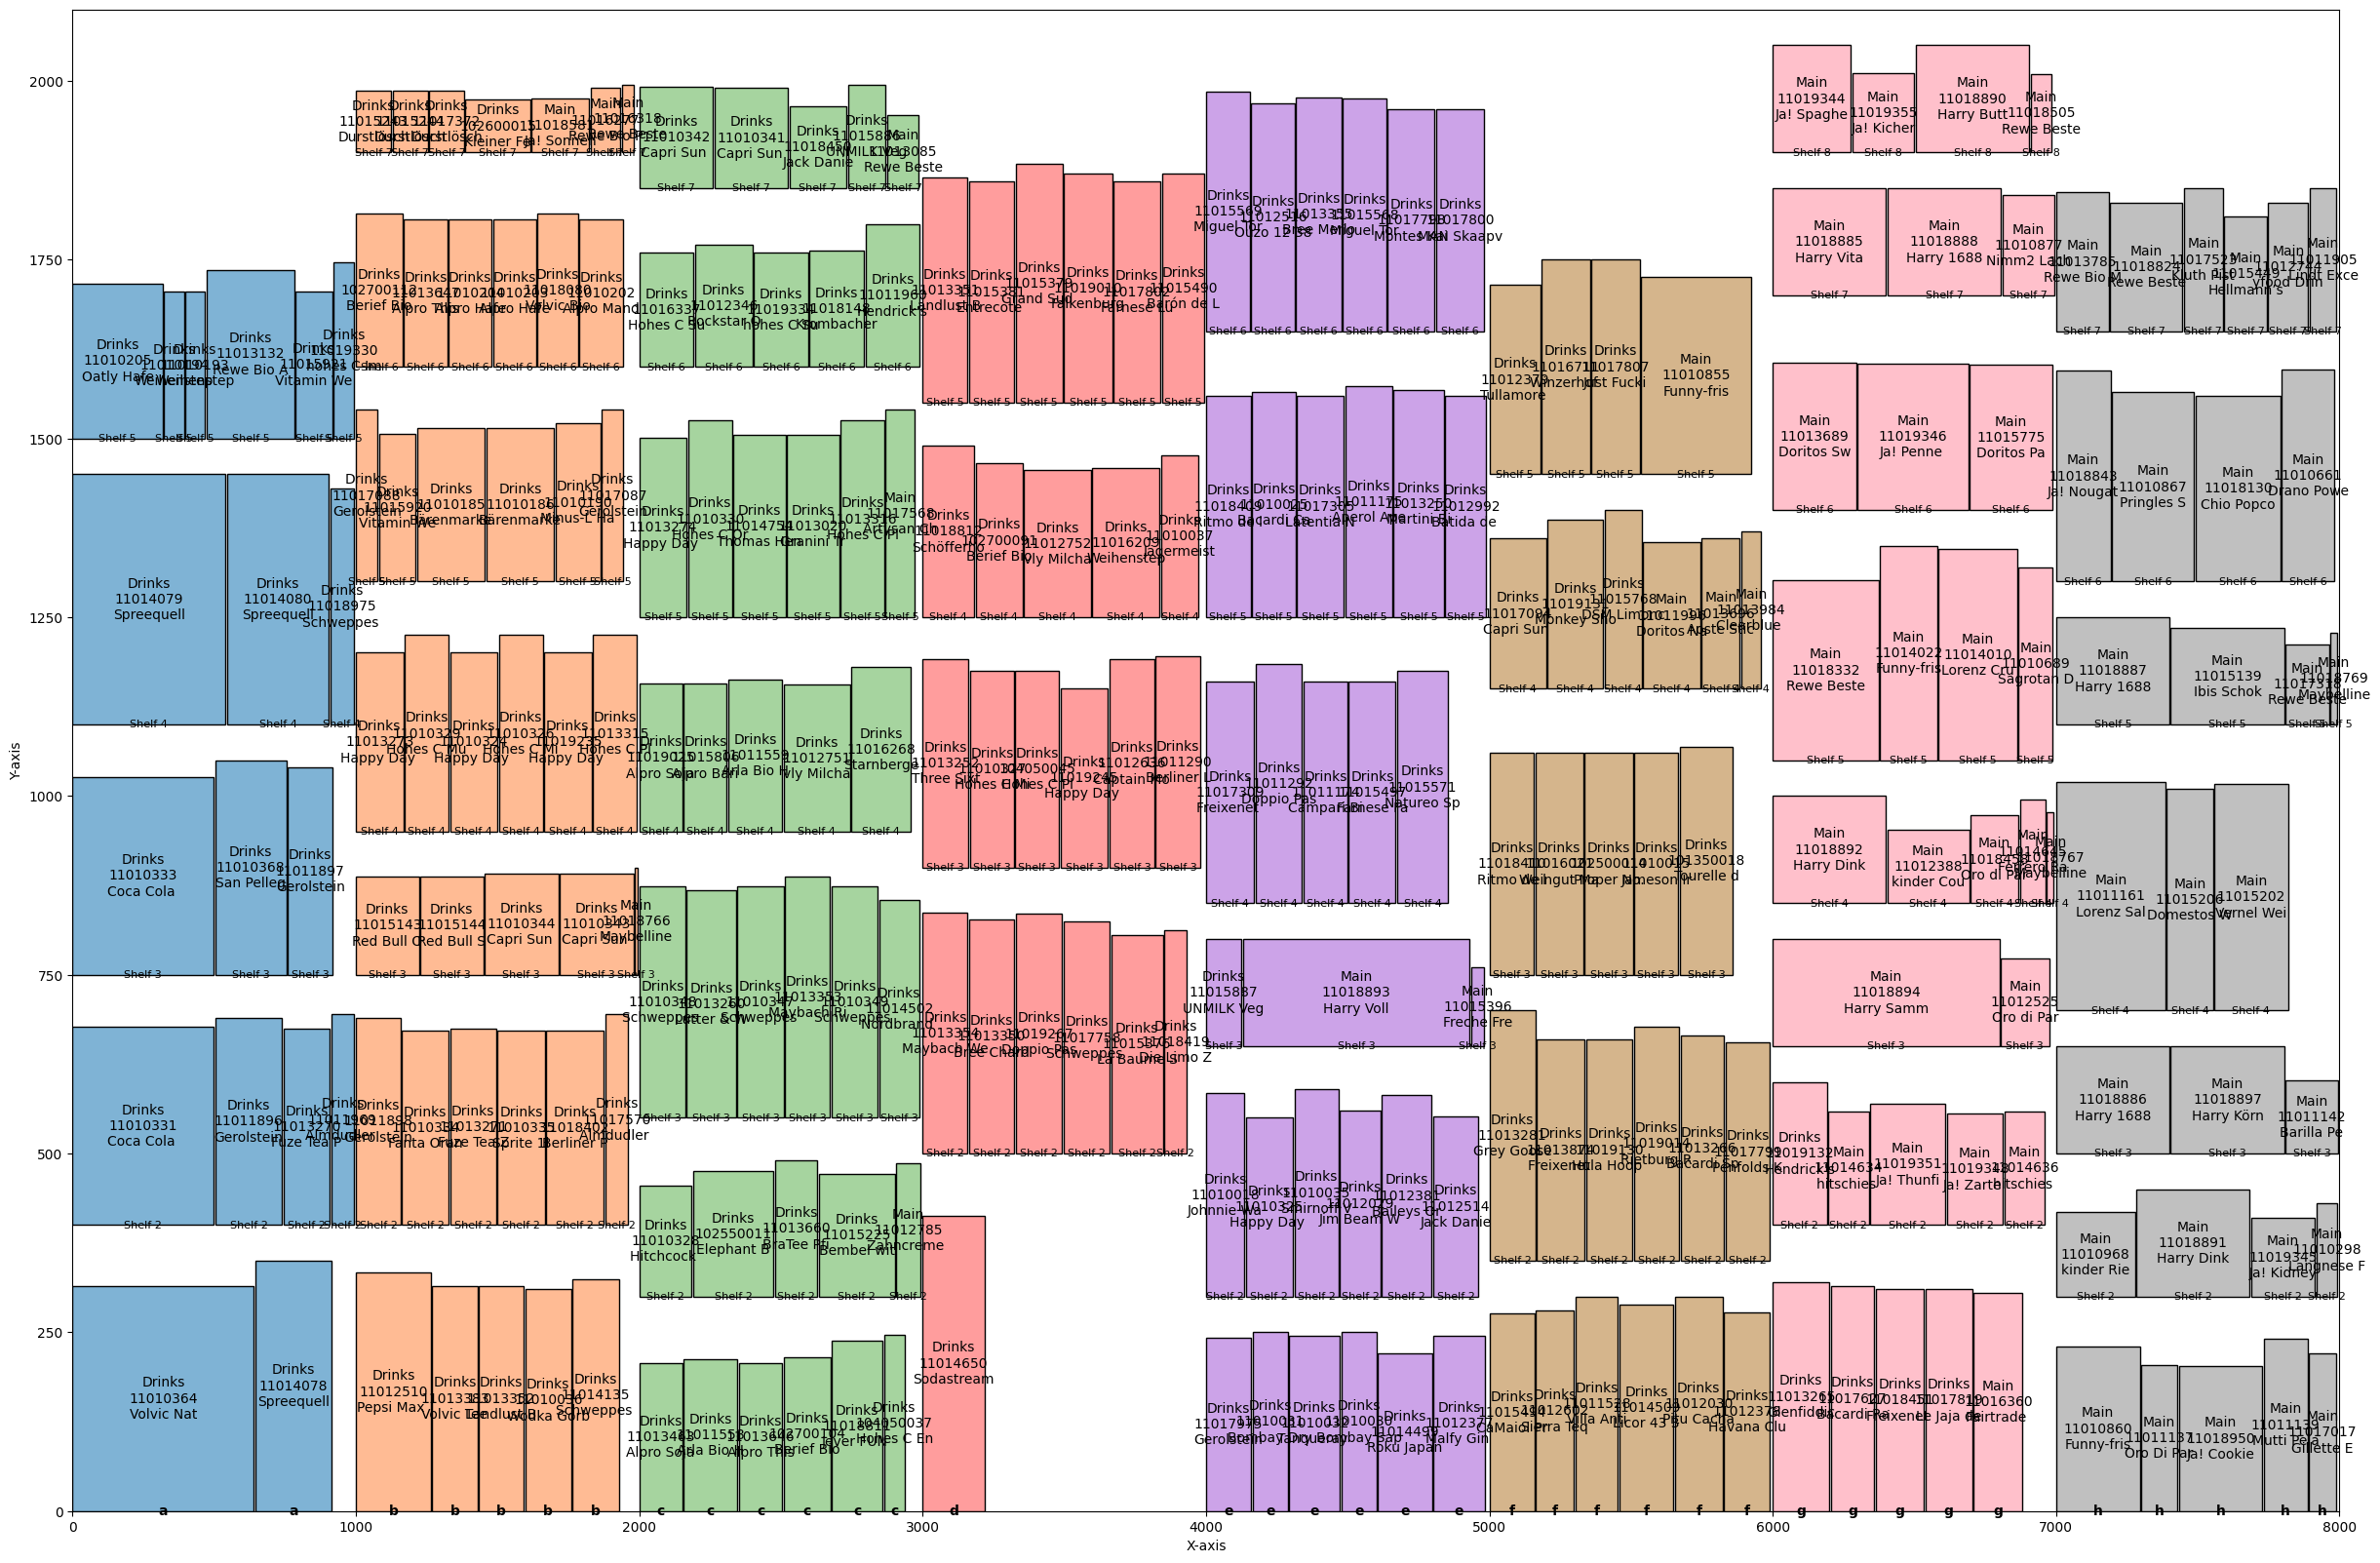

In [184]:
item_data = planogram
# Create a new figure
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(30)

# Plot each planogram item as a rectangle
for item in item_data:
    rect = plt.Rectangle((item['x'], item['y']), item['width'], item['height'],
                         edgecolor='black', facecolor=colors[item['rackId']])
    ax.add_patch(rect)
    ax.annotate(item['text'], (item['x'] + 0.5 * item['width'], item['y'] + 0.5 * item['height']),
                color='black', ha='center', va='center')
    if item['shelfNumber'] == 1:
      ax.text(item['x'] + 0.5 * item['width'], item['y'] - 0.5, item['rackId'],
            color='black', ha='center', va='center', fontsize=10, fontweight='bold')
    else:
      ax.text(item['x'] + 0.5 * item['width'], item['y'] - 0.2, f"Shelf {item['shelfNumber']}",
            color='black', ha='center', va='center', fontsize=8)

# Set the axis limits and labels
ax.set_xlim(0, 8000)
ax.set_ylim(0, 2100)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot

plt.show()
